# 42576 From analytics to action, Spring 2025

Rigshospitalet case presentation from group 7:

- Fie Christina Møller (s205291)
- Gonçalo Alexandre Baeta Rebelo de Sousa (s232656)
- Inês Da Fonseca Tacanho (s232669)
- Margarida Neto Iria Varanda Gonçalves (s233528)
- Nikolai Outzen Wegge-Berg (s195387)
- Raquel Moleiro Marques (s243636)

### Imports

In [1]:
import re
import folium
import textwrap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import branca.colormap as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from folium.plugins import HeatMap
from sklearn.decomposition import PCA
from geopy.geocoders import Nominatim
from sklearn.pipeline import Pipeline
from IPython.display import display, HTML
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from geopy.extra.rate_limiter import RateLimiter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

__________

## Data Preparation

In [2]:
df = pd.read_csv("Case Rigshospitalet Translated.csv")
df

/var/folders/42/jzdlm0tx6bld5l7c53yw5zjc0000gn/T/ipykernel_91487/4077267614.py:1: DtypeWarning: Columns (9,13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Case Rigshospitalet Translated.csv")


,Patient ID,Patient Contact ID,Patient Age at Contact Start Time,Contact Start Date,Contact End Date,Contact Type,Admission Method,Patient Contact Type,Primary Diagnosis Code,Secondary Diagnosis Code,...,Admission Method Translated,Patient Contact Type Translated,Responsible Treatment Department Translated,Visit Type Translated,Patient Bio Gender Translated,Patient Marital Status Translated,Patient Created on My SP (Y/N) Translated,Patient Country Translated,Patient Region Translated,Patient Municipality Translated
0,Z4115614,1301023075465,0,"2023-01-13 12:32:00,000","2023-01-13 13:02:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
1,Z4115614,1301023121831,0,"2023-01-15 13:27:00,000","2023-01-15 13:57:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
2,Z4119225,1301023357249,0,"2023-01-30 10:20:00,000","2023-01-30 10:50:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
3,Z4127033,1301023443807,0,"2023-02-04 12:46:00,000","2023-02-04 13:16:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
4,Z4127033,1301023443875,0,"2023-02-05 12:22:00,000","2023-02-05 12:52:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4658061,Z3524545,1301024938526,39,"2023-05-31 09:26:00,000","2023-05-31 10:15:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBST RH MEDICINAL PRODUCT*,Female,Single,J,Denmark,Capital (84),Copenhagen
4658062,Z3524545,1301025230953,40,"2023-06-13 12:39:00,000","2023-06-13 13:20:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBST SOFT 40,Female,Single,J,Denmark,Capital (84),Copenhagen
4658063,Z3524545,1301025584370,40,"2023-06-27 12:22:00,000","2023-06-27 13:00:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBST RH MEDICINAL PRODUCT*,Female,Single,J,Denmark,Capital (84),Copenhagen
4658064,Z3524545,1301025584370,40,"2023-06-27 12:22:00,000","2023-06-27 13:00:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBST RH MEDICINAL PRODUCT*,Female,Single,J,Denmark,Capital (84),Copenhagen


In [3]:
df = df.drop(columns=['Primary Procedure Code', 'Secondary Procedure Code'])
df

,Patient ID,Patient Contact ID,Patient Age at Contact Start Time,Contact Start Date,Contact End Date,Contact Type,Admission Method,Patient Contact Type,Primary Diagnosis Code,Secondary Diagnosis Code,...,Admission Method Translated,Patient Contact Type Translated,Responsible Treatment Department Translated,Visit Type Translated,Patient Bio Gender Translated,Patient Marital Status Translated,Patient Created on My SP (Y/N) Translated,Patient Country Translated,Patient Region Translated,Patient Municipality Translated
0,Z4115614,1301023075465,0,"2023-01-13 12:32:00,000","2023-01-13 13:02:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
1,Z4115614,1301023121831,0,"2023-01-15 13:27:00,000","2023-01-15 13:57:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
2,Z4119225,1301023357249,0,"2023-01-30 10:20:00,000","2023-01-30 10:50:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
3,Z4127033,1301023443807,0,"2023-02-04 12:46:00,000","2023-02-04 13:16:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
4,Z4127033,1301023443875,0,"2023-02-05 12:22:00,000","2023-02-05 12:52:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4658061,Z3524545,1301024938526,39,"2023-05-31 09:26:00,000","2023-05-31 10:15:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBST RH MEDICINAL PRODUCT*,Female,Single,J,Denmark,Capital (84),Copenhagen
4658062,Z3524545,1301025230953,40,"2023-06-13 12:39:00,000","2023-06-13 13:20:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBST SOFT 40,Female,Single,J,Denmark,Capital (84),Copenhagen
4658063,Z3524545,1301025584370,40,"2023-06-27 12:22:00,000","2023-06-27 13:00:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBST RH MEDICINAL PRODUCT*,Female,Single,J,Denmark,Capital (84),Copenhagen
4658064,Z3524545,1301025584370,40,"2023-06-27 12:22:00,000","2023-06-27 13:00:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBST RH MEDICINAL PRODUCT*,Female,Single,J,Denmark,Capital (84),Copenhagen


In [4]:
df = df.drop_duplicates()
df

,Patient ID,Patient Contact ID,Patient Age at Contact Start Time,Contact Start Date,Contact End Date,Contact Type,Admission Method,Patient Contact Type,Primary Diagnosis Code,Secondary Diagnosis Code,...,Admission Method Translated,Patient Contact Type Translated,Responsible Treatment Department Translated,Visit Type Translated,Patient Bio Gender Translated,Patient Marital Status Translated,Patient Created on My SP (Y/N) Translated,Patient Country Translated,Patient Region Translated,Patient Municipality Translated
0,Z4115614,1301023075465,0,"2023-01-13 12:32:00,000","2023-01-13 13:02:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
1,Z4115614,1301023121831,0,"2023-01-15 13:27:00,000","2023-01-15 13:57:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
2,Z4119225,1301023357249,0,"2023-01-30 10:20:00,000","2023-01-30 10:50:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
3,Z4127033,1301023443807,0,"2023-02-04 12:46:00,000","2023-02-04 13:16:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
4,Z4127033,1301023443875,0,"2023-02-05 12:22:00,000","2023-02-05 12:52:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBSERVED AFTER BIRTH 30,Male,Single,J,Denmark,Capital (84),Copenhagen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4658058,Z3524545,1301024819457,39,"2023-05-30 08:28:00,000","2023-05-30 11:28:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBST AND OBST,Female,Single,J,Denmark,Capital (84),Copenhagen
4658060,Z3524545,1301024876038,39,"2023-05-30 11:28:00,000","2023-05-30 12:08:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBST SOFT 40,Female,Single,J,Denmark,Capital (84),Copenhagen
4658061,Z3524545,1301024938526,39,"2023-05-31 09:26:00,000","2023-05-31 10:15:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBST RH MEDICINAL PRODUCT*,Female,Single,J,Denmark,Capital (84),Copenhagen
4658062,Z3524545,1301025230953,40,"2023-06-13 12:39:00,000","2023-06-13 13:20:00,000",Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Planned,2 Ambulant,"RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM",OBST SOFT 40,Female,Single,J,Denmark,Capital (84),Copenhagen


In [5]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

Missing values per column:
Patient ID                                28
Primary Diagnosis Code                   295
Secondary Diagnosis Code             1697198
Procedure Performed                    51203
Visit Type                            510707
Patient Postal Code                    16795
Visit Type Translated                 510707
Patient Bio Gender Translated             28
Patient Marital Status Translated       4352
Patient Country Translated              7743
Patient Region Translated               7517
Patient Municipality Translated         7276
dtype: int64


In [6]:
# Define a lambda function to clean timestamp strings by removing seconds and milliseconds (e.g., ':22,123')
finddate_format =lambda x: re.sub(r":\d{2},\d{3}$", "", x)

# Apply the cleaning function to 'Contact Start Date' and 'Contact End Date' columns
df['Contact Start Date'] = df['Contact Start Date'].apply(finddate_format)
df['Contact End Date'] = df['Contact End Date'].apply(finddate_format)

# Convert the cleaned string columns to proper datetime objects (format: YYYY-MM-DD HH:MM)
df['Contact Start Date'] = pd.to_datetime(df['Contact Start Date'], format='%Y-%m-%d %H:%M')
df['Contact End Date'] = pd.to_datetime(df['Contact End Date'], format='%Y-%m-%d %H:%M')

/var/folders/42/jzdlm0tx6bld5l7c53yw5zjc0000gn/T/ipykernel_91487/4218239585.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Contact Start Date'] = df['Contact Start Date'].apply(finddate_format)
/var/folders/42/jzdlm0tx6bld5l7c53yw5zjc0000gn/T/ipykernel_91487/4218239585.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Contact End Date'] = df['Contact End Date'].apply(finddate_format)
/var/folders/42/jzdlm0tx6bld5l7c53yw5zjc0000gn/T/ipykernel_91487/4218239585.py:9: SettingWithCopyWarning: 
A v

In [7]:
# The time period of the data
min_date = min(df['Contact Start Date'])
max_date = max(df['Contact End Date'])
print("The earliest contact start date is", min_date)
print("The latest contact end date is", max_date)
number_of_days = (max_date - min_date).days
print("The number of days between the earliest and latest contact dates is", number_of_days,)

The earliest contact start date is 2023-01-01 00:11:00
The latest contact end date is 2024-12-31 21:45:00
The number of days between the earliest and latest contact dates is 730


In [8]:
diagnosis_data = pd.read_csv('Diagnosis dimension table for Case Rigshospitalet Translated.csv')
diagnosis_data

,Primary Diagnosis Code,Primary Diagnosis Text,Group 3,Group 2,Group 1,Primary Diagnosis Text Translated
0,DA00,Kolera,Infektiøse tarmsygdomme,Infektiøse tarmsygdomme,Visse infektiøse og parasitære sygdomme,Cholera
1,DA000,Kolera forårsaget af Vibrio cholerae,Infektiøse tarmsygdomme,Infektiøse tarmsygdomme,Visse infektiøse og parasitære sygdomme,Cholera caused by Vibrio cholerae
2,DA001,Kolera forårsaget af Vibrio cholerae eltor,Infektiøse tarmsygdomme,Infektiøse tarmsygdomme,Visse infektiøse og parasitære sygdomme,Cholera caused by Vibrio cholerae eltor
3,DA009,Kolera UNS,Infektiøse tarmsygdomme,Infektiøse tarmsygdomme,Visse infektiøse og parasitære sygdomme,Kholera UNS
4,DA01,Tyfus og paratyfus,Infektiøse tarmsygdomme,Infektiøse tarmsygdomme,Visse infektiøse og parasitære sygdomme,Typhoid and paratyphus
...,...,...,...,...,...,...
19477,DZ998,Afhængighed af andet hjælpemiddel eller apparat,Personer med potentiel helbredsrisiko i relati...,Personer med potentiel helbredsrisiko i relati...,Faktorer af betydning for sundhedstilstand og ...,Dependency on other means or apparatus
19478,DZ998A,Afhængig af hjælpemiddel ved søvnapnø,Personer med potentiel helbredsrisiko i relati...,Personer med potentiel helbredsrisiko i relati...,Faktorer af betydning for sundhedstilstand og ...,Depending on aid in sleep apnea
19479,DZ998B,Afhængig af hjælpemiddel til gang,Personer med potentiel helbredsrisiko i relati...,Personer med potentiel helbredsrisiko i relati...,Faktorer af betydning for sundhedstilstand og ...,Depending on aid for walking
19480,DZ998C,Afhængig af hjælpemiddel til kommunikation,Personer med potentiel helbredsrisiko i relati...,Personer med potentiel helbredsrisiko i relati...,Faktorer af betydning for sundhedstilstand og ...,Depending on means of communication


In [9]:
unique_diagnosis = diagnosis_data['Primary Diagnosis Code'].unique()
print("Unique primary diagnosis codes:", unique_diagnosis)
count_unique_diagnosis = len(unique_diagnosis)
print("Number of unique primary diagnosis codes:", count_unique_diagnosis)

Unique primary diagnosis codes: ['DA00' 'DA000' 'DA001' ... 'DZ998B' 'DZ998C' 'DZ999']
Number of unique primary diagnosis codes: 19482


In [10]:
# Merge the main consultation data (df) with additional diagnosis information (diagnosis_data)
df = pd.merge(df, diagnosis_data, on='Primary Diagnosis Code', how='left')
df

,Patient ID,Patient Contact ID,Patient Age at Contact Start Time,Contact Start Date,Contact End Date,Contact Type,Admission Method,Patient Contact Type,Primary Diagnosis Code,Secondary Diagnosis Code,...,Patient Marital Status Translated,Patient Created on My SP (Y/N) Translated,Patient Country Translated,Patient Region Translated,Patient Municipality Translated,Primary Diagnosis Text,Group 3,Group 2,Group 1,Primary Diagnosis Text Translated
0,Z4115614,1301023075465,0,2023-01-13 12:32:00,2023-01-13 13:02:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Single,J,Denmark,Capital (84),Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...
1,Z4115614,1301023121831,0,2023-01-15 13:27:00,2023-01-15 13:57:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Single,J,Denmark,Capital (84),Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...
2,Z4119225,1301023357249,0,2023-01-30 10:20:00,2023-01-30 10:50:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Single,J,Denmark,Capital (84),Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...
3,Z4127033,1301023443807,0,2023-02-04 12:46:00,2023-02-04 13:16:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Single,J,Denmark,Capital (84),Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...
4,Z4127033,1301023443875,0,2023-02-05 12:22:00,2023-02-05 12:52:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Single,J,Denmark,Capital (84),Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2302416,Z3524545,1301024819457,39,2023-05-30 08:28:00,2023-05-30 11:28:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Single,J,Denmark,Capital (84),Copenhagen,"Graviditet, førstegangsfødende",Personer i kontakt med sundhedsvæsenet i relat...,Personer i kontakt med sundhedsvæsenet i relat...,Faktorer af betydning for sundhedstilstand og ...,"Pregnancy, first-time feeding"
2302417,Z3524545,1301024876038,39,2023-05-30 11:28:00,2023-05-30 12:08:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Single,J,Denmark,Capital (84),Copenhagen,"Graviditet, førstegangsfødende",Personer i kontakt med sundhedsvæsenet i relat...,Personer i kontakt med sundhedsvæsenet i relat...,Faktorer af betydning for sundhedstilstand og ...,"Pregnancy, first-time feeding"
2302418,Z3524545,1301024938526,39,2023-05-31 09:26:00,2023-05-31 10:15:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Single,J,Denmark,Capital (84),Copenhagen,"Graviditet, førstegangsfødende",Personer i kontakt med sundhedsvæsenet i relat...,Personer i kontakt med sundhedsvæsenet i relat...,Faktorer af betydning for sundhedstilstand og ...,"Pregnancy, first-time feeding"
2302419,Z3524545,1301025230953,40,2023-06-13 12:39:00,2023-06-13 13:20:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Single,J,Denmark,Capital (84),Copenhagen,"Graviditet, førstegangsfødende",Personer i kontakt med sundhedsvæsenet i relat...,Personer i kontakt med sundhedsvæsen

_________

## Data Exploration

### Gender Distribution

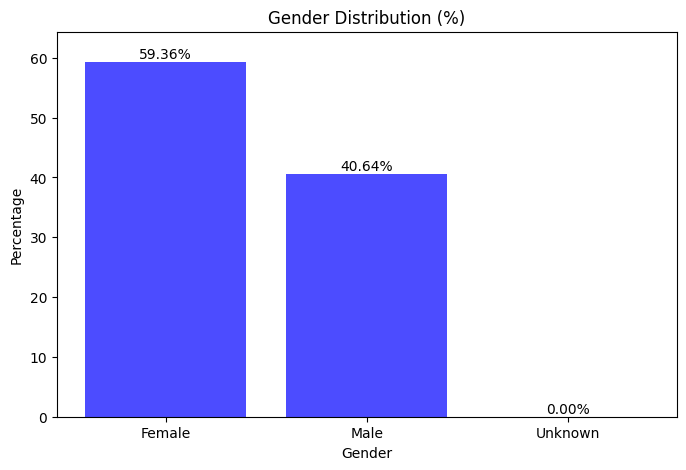

In [11]:
df['Patient Bio Gender'] = df['Patient Bio Gender Translated'].replace({'Kvinde': 'Female', 'Mand': 'Male', 'Ukendt': 'Unknown'})

# Count occurrences of each gender
gender_counts = df['Patient Bio Gender'].value_counts()

# Convert counts to percentages
gender_percentages = (gender_counts / gender_counts.sum()) * 100

plt.figure(figsize=(8, 5))
plt.bar(gender_percentages.index, gender_percentages.values, color=['blue'], alpha=0.7)
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Gender Distribution (%)')

# Show percentages on bars with higher precision for small values
for i, v in enumerate(gender_percentages.values):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontsize=10)  # More decimal places

# Adjust y-axis for better visibility
plt.ylim(0, max(gender_percentages.values) + 5)  # Dynamic y-axis scaling
plt.show()

### Top 5 Procedures

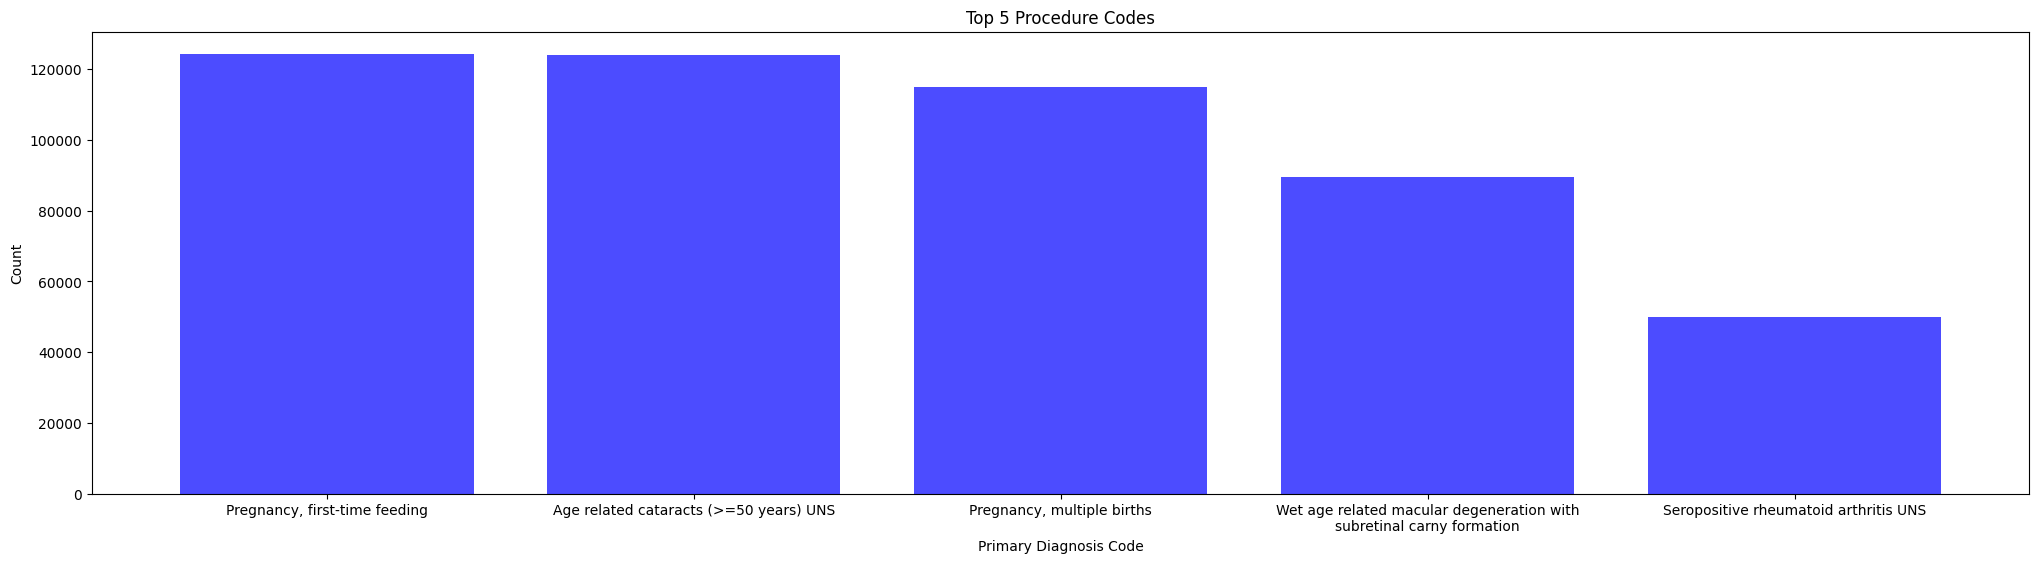

In [12]:
# Procedure types
procedure_counts = df['Primary Diagnosis Code'].value_counts().head(5)

# MATCHING PROCEDURE CODES WITH THEIR DESCRIPTIONS
procedure_counts = procedure_counts.reset_index()
procedure_counts.columns = ['Primary Diagnosis Code', 'Count']
procedure_counts['Description'] = procedure_counts['Primary Diagnosis Code'].map(
	lambda x: diagnosis_data[diagnosis_data['Primary Diagnosis Code'] == x]['Primary Diagnosis Text'].values[0] 
	if not diagnosis_data[diagnosis_data['Primary Diagnosis Code'] == x].empty else 'Unknown'
)
procedure_counts['Description Translated'] = procedure_counts['Primary Diagnosis Code'].map(
	lambda x: diagnosis_data[diagnosis_data['Primary Diagnosis Code'] == x]['Primary Diagnosis Text Translated'].values[0] 
	if not diagnosis_data[diagnosis_data['Primary Diagnosis Code'] == x].empty else 'Unknown' )

# Wrap long text into two lines
procedure_counts['Description Translated'] = procedure_counts['Description Translated'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=50)))

plt.figure(figsize=(25, 6))
plt.bar(procedure_counts['Description Translated'], procedure_counts['Count'], color='blue', alpha=0.7)
plt.xlabel('Primary Diagnosis Code')
plt.ylabel('Count')
plt.title('Top 5 Procedure Codes')
plt.show()

In [13]:
procedure_counts.head(5)

,Primary Diagnosis Code,Count,Description,Description Translated
0,DZ340,124385,"Graviditet, førstegangsfødende","Pregnancy, first-time feeding"
1,DH259,124104,Aldersbetinget grå stær (>=50 år) UNS,Age related cataracts (>=50 years) UNS
2,DZ348A,115004,"Graviditet, flergangsfødende","Pregnancy, multiple births"
3,DH353J,89551,Våd aldersrelateret makuladegeneration med sub...,Wet age related macular degeneration with\nsub...
4,DM059,49984,Seropositiv reumatoid artritis UNS,Seropositive rheumatoid arthritis UNS


### Appointment Types Distribution

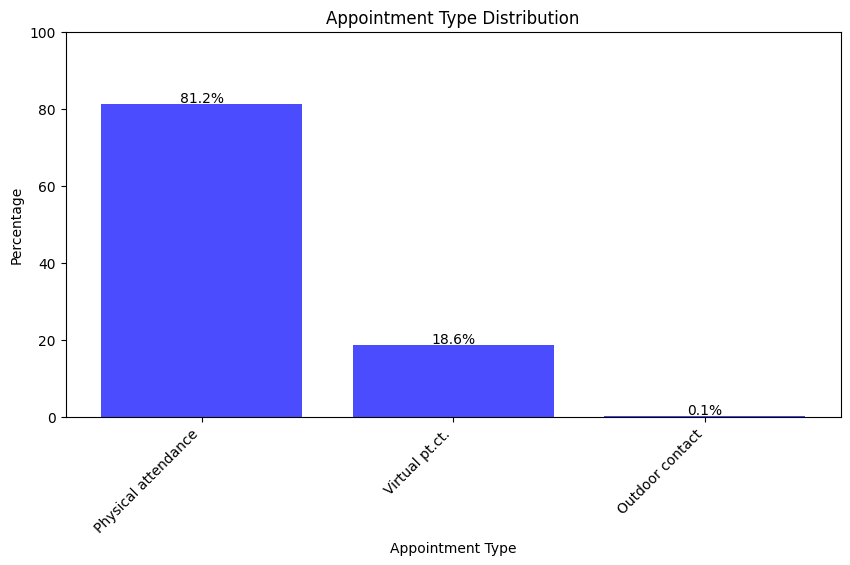

In [14]:
# Count occurrences of each appointment type
appointment_counts = df['Contact Type Translated'].value_counts()

# Convert counts to percentages
appointment_percentages = (appointment_counts / appointment_counts.sum()) * 100

# Plot
plt.figure(figsize=(10, 5))
plt.bar(appointment_percentages.index, appointment_percentages.values, color='blue', alpha=0.7)
plt.xlabel('Appointment Type')
plt.ylabel('Percentage')
plt.title('Appointment Type Distribution')

# Show percentages on bars
for i, v in enumerate(appointment_percentages.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

### Top Departments with Most Outpatient Activities

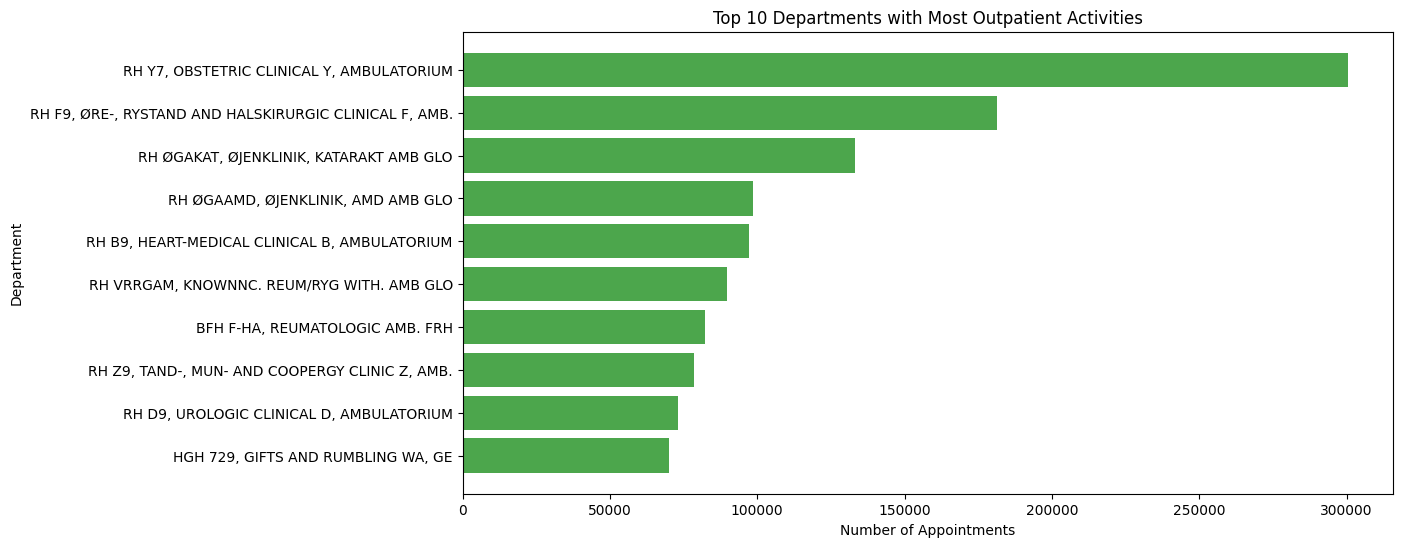

In [15]:
# Count outpatient activities per department
top_departments = df['Responsible Treatment Department Translated'].value_counts().head(10)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_departments.index, top_departments.values, color='green', alpha=0.7)
plt.xlabel('Number of Appointments')
plt.ylabel('Department')
plt.title('Top 10 Departments with Most Outpatient Activities')

plt.gca().invert_yaxis()  # To display highest count at the top
plt.show()


### Total Appointments per Patient (Distribution Analysis)

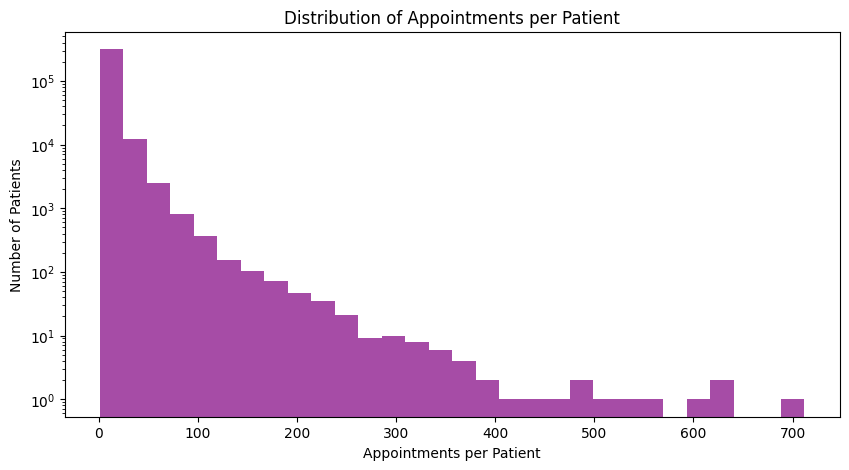

In [16]:
# Count appointments per patient
appointments_per_patient = df['Patient ID'].value_counts()

# Plot histogram to see distribution
plt.figure(figsize=(10, 5))
plt.hist(appointments_per_patient, bins=30, color='purple', alpha=0.7)
plt.xlabel('Appointments per Patient')
plt.ylabel('Number of Patients')
plt.title('Distribution of Appointments per Patient')
plt.yscale('log')  # Log scale to show the long tail effect
plt.show()

### Identify Top 10% of Patients with Most Appointments

In [17]:
# Find the top 10% threshold
top_10_percent_threshold = np.percentile(appointments_per_patient, 90)

# Get patients in the top 10%
top_10_percent_patients = appointments_per_patient[appointments_per_patient >= top_10_percent_threshold].index

# Subset data for these patients
top_patients_data = df[df['Patient ID'].isin(top_10_percent_patients)]

### Compare Top 10% Patients vs. General Population
#### Age distribution

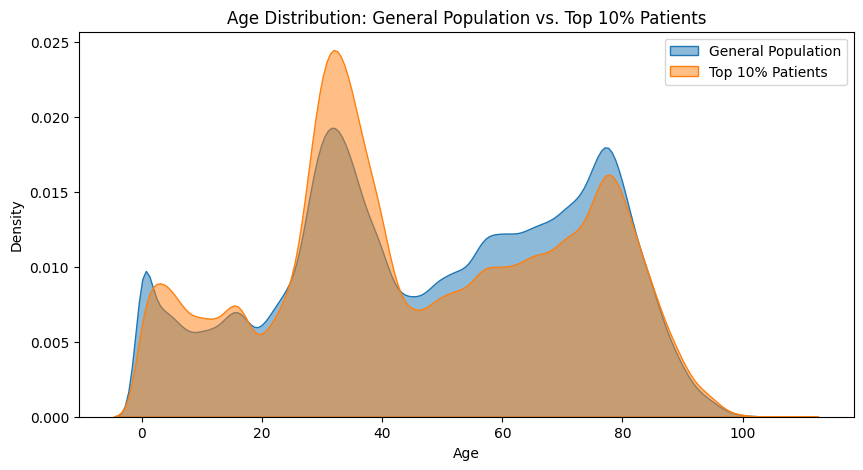

In [18]:
# General Population vs. High-Utilizers (Top 10% of patients)
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='Patient Age at Contact Start Time', label='General Population', fill=True, alpha=0.5)
sns.kdeplot(data=top_patients_data, x='Patient Age at Contact Start Time', label='Top 10% Patients', fill=True, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution: General Population vs. Top 10% Patients')
plt.legend()
plt.show()

#### Gender distribution

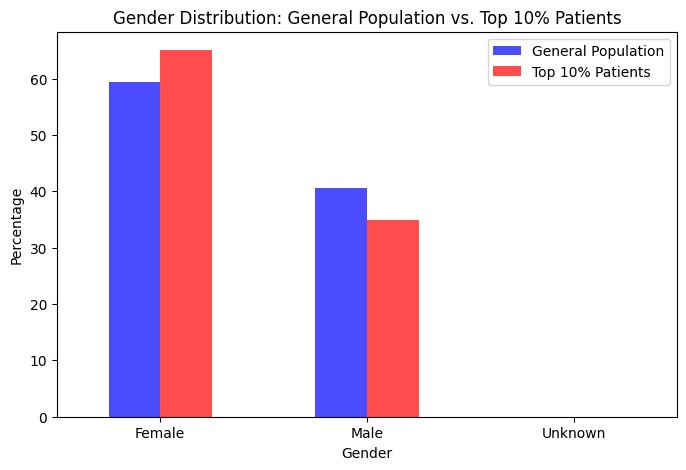

In [19]:
# Gender distribution for both groups
general_gender_dist = df['Patient Bio Gender Translated'].value_counts(normalize=True) * 100
top_gender_dist = top_patients_data['Patient Bio Gender Translated'].value_counts(normalize=True) * 100

# Create a dataframe for comparison
gender_comparison = pd.DataFrame({'General Population': general_gender_dist, 'Top 10% Patients': top_gender_dist}).fillna(0)

# Plot
gender_comparison.plot(kind='bar', figsize=(8, 5), color=['blue', 'red'], alpha=0.7)
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Gender Distribution: General Population vs. Top 10% Patients')
plt.xticks(rotation=0)
plt.legend()
plt.show()

### Appointment durations

Converting the dates to datetime so it can be handled and calculating the average meeting duration of all appointments.

In [20]:
# Calculate duration in minutes
df['Duration (minutes)'] = (df['Contact End Date'] - df['Contact Start Date']).dt.total_seconds() / 60

# Calculate average duration
average_duration = df['Duration (minutes)'].mean()


print(f"Average call duration: {average_duration:.2f} minutes")

Average call duration: 94.70 minutes


Histogram to see how many appointments are spanding over x amount of days

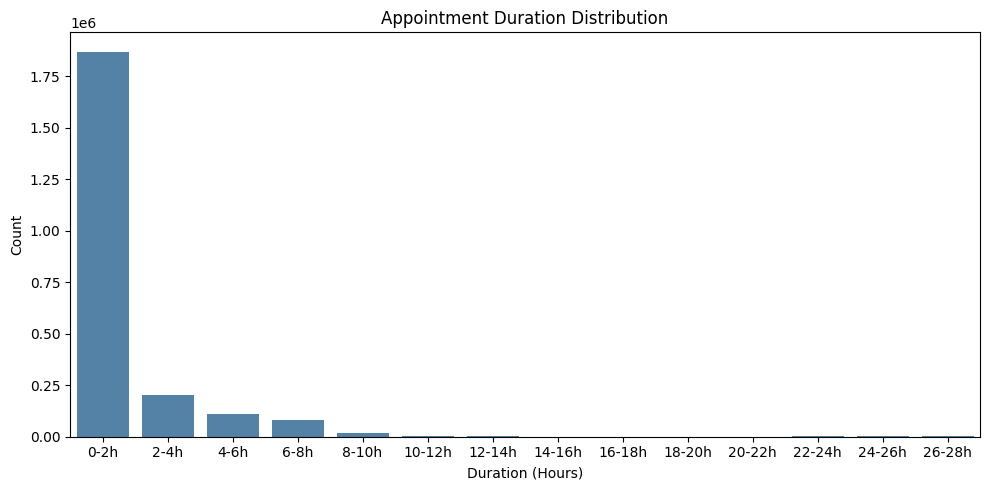

In [21]:
# Calculate duration in hours
duration_hours = (df['Contact End Date'] - df['Contact Start Date']).dt.total_seconds() / 3600

# Define custom bins (you can adjust the range as needed)
bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
labels = ['0-2h', '2-4h', '4-6h', '6-8h', '8-10h', '10-12h', '12-14h', '14-16h', '16-18h', '18-20h', '20-22h', '22-24h', '24-26h', '26-28h']

# Bin the durations
df['Duration Category'] = pd.cut(duration_hours, bins=bins, labels=labels, right=False)

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Duration Category', color='steelblue')
plt.title('Appointment Duration Distribution')
plt.xlabel('Duration (Hours)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Mean duration of consultation that is only in one day

In [22]:
duration = df['Duration (minutes)']
duration[duration < 24*60].mean()

88.84808520646148

Very close to the same average so there can only be very few, very long consultations.

Group average meeting duration by the start time of the day.

2288121


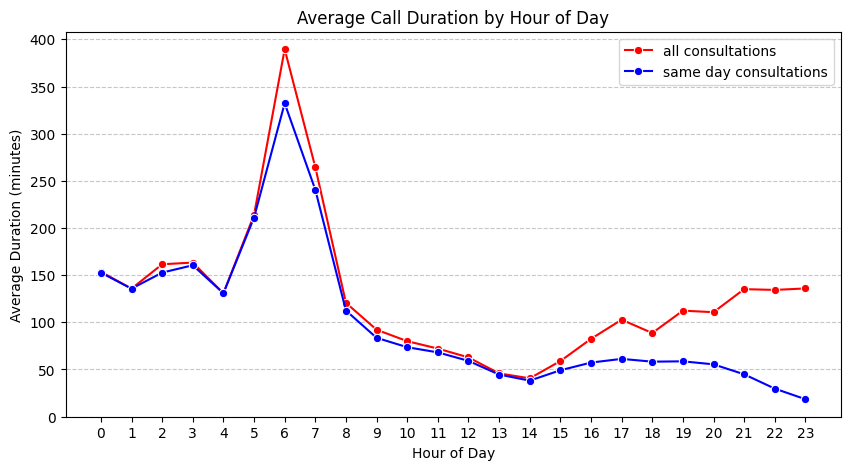

In [23]:
df['Hour of Day'] = df['Contact Start Date'].dt.hour

# group by hour of day
average_by_hour = df.groupby('Hour of Day')['Duration (minutes)'].mean().reset_index()

# filter data to only include one day consultations
one_day_data = df[df['Contact Start Date'].dt.date == df['Contact End Date'].dt.date]

average_by_hour_day = one_day_data.groupby('Hour of Day')['Duration (minutes)'].mean().reset_index()
print(len(one_day_data))
plt.figure(figsize=(10, 5))
sns.lineplot(data=average_by_hour, x='Hour of Day', y='Duration (minutes)', color='red', marker='o', label = "all consultations")
sns.lineplot(data=average_by_hour_day, x='Hour of Day', y='Duration (minutes)', color='blue', marker='o', label = "same day consultations")
plt.xlabel('Hour of Day')
plt.ylabel('Average Duration (minutes)')
plt.title('Average Call Duration by Hour of Day')
plt.xticks(range(24))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We can see that in both 1 day consultaion and all consultation, there is a trend that most consultations starting outside "normal" business hours tend to be way longer. Probably due to them being urgent instead of normal consultations.

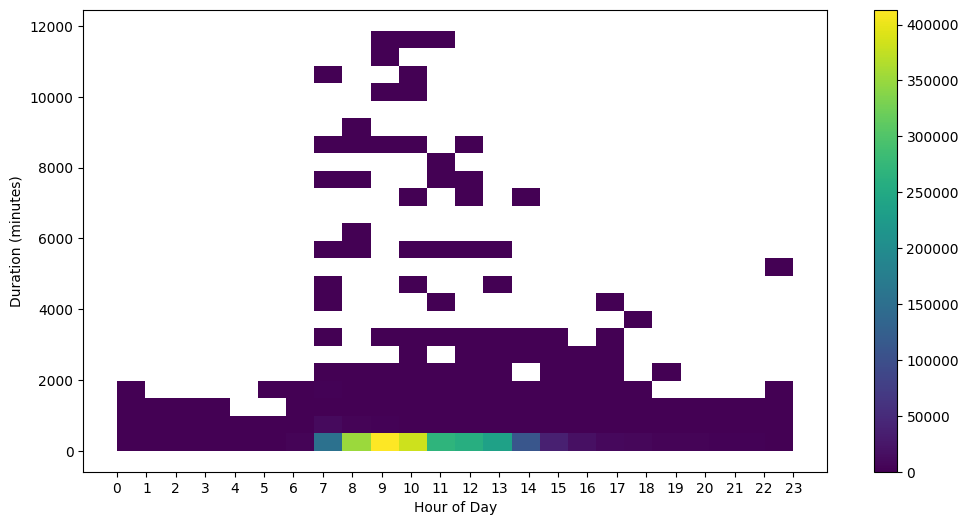

In [24]:
# histogram of duration per hour of day
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Hour of Day', y='Duration (minutes)', bins=24, cmap='viridis', cbar=True)
plt.xlabel('Hour of Day')
plt.xticks(range(24))
plt.show()

A "heatmap" of a kind to see at what time of day not only most consultations happen but also at what time of the day we see the outliers, very long consultations, start.

## Without all pregnancy-related consultations

In [25]:
# Defining the list of pregnancy-related diagnosis codes
pregnancy_codes = ['RH Y7, OBSTETRIC CLINICAL Y, AMBULATORIUM']

# Remove rows with pregnancy-related diagnosis codes
df_non_pregnancy = df[~df['Responsible Treatment Department Translated'].isin(pregnancy_codes)]

# Display the updated dataframe
df_non_pregnancy

,Patient ID,Patient Contact ID,Patient Age at Contact Start Time,Contact Start Date,Contact End Date,Contact Type,Admission Method,Patient Contact Type,Primary Diagnosis Code,Secondary Diagnosis Code,...,Patient Municipality Translated,Primary Diagnosis Text,Group 3,Group 2,Group 1,Primary Diagnosis Text Translated,Patient Bio Gender,Duration (minutes),Duration Category,Hour of Day
6863,Z4030762,1301023084574,0,2023-02-07 09:18:00,2023-02-07 10:00:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Male,42.0,0-2h,9
6864,Z4056993,1301023289336,0,2023-01-26 10:50:00,2023-01-26 11:20:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Female,30.0,0-2h,10
6865,Z4066021,1301023486523,0,2023-03-10 08:25:00,2023-03-10 09:00:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Male,35.0,0-2h,8
6866,Z4098041,1301022818412,0,2023-01-04 10:19:00,2023-01-04 13:30:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Female,191.0,2-4h,10
6867,Z4108696,1301027209839,0,2023-10-18 09:56:00,2023-10-18 10:30:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Female,34.0,0-2h,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276111,Z3240475,1301027392577,5,2023-11-23 09:05:00,2023-11-23 11:43:00,Fysisk fremmøde,Planlagt,4 Ambulant Us/Op,DK222B,DT286,...,Copenhagen,Stenose i spiserøret,"Sygdomme i spiserøret, mavesækken og tolvfinge...","Sygdomme i spiserøret, mavesækken og tolvfinge...",Sygdomme i fordøjelsesorganer,Stenosis in the esophagus,Female,158.0,2-4h,9
2276112,Z3240475,1301027392577,5,2023-11-23 09:05:00,2023-11-23 11:43:00,Fysisk fremmøde,Planlagt,4 Ambulant Us/Op,DK222B,DT286,...,Copenhagen,Stenose i spiserøret,"Sygdomme i spiserøret, mavesækken og tolvfinge...","Sygdomme i spiserøret, mavesækken og tolvfinge...",Sygdomme i fordøjelsesorganer,Stenosis in the esophagus,Female,158.0,2-4h,9
2276113,Z3240475,1301027392577,5,2023-11-23 09:05:00,2023-11-23 11:43:00,Fysisk fremmøde,Planlagt,4 Ambulant Us/Op,DK222B,DT286,...,Copenhagen,Stenose i spiserøret,"Sygdomme i spiserøret, mavesækken og tolvfinge...","Sygdomme i spiserøret, mavesækken og tolvfinge...",Sygdomme i fordøjelsesorganer,Stenosis in the esophagus,Female,158.0,2-4h,9
2276114,Z3240475,1301027392577,5,2023-11-23 09:05:00,2023-11-23 11:43:00,Fysisk fremmøde,Planlagt,4 Ambulant Us/Op,DK222B,DT286,...,Copenhagen,Stenose i spiserøret,"Sygdomme i spiserøret, mavesækken og tolvfinge...","Sygdomme i spiserøret, mavesækken og tolvfinge...",Sygdomme i fordøjelsesorganer,Stenosis in the esophagus,Female,158.0,2-4h,9


In [26]:
# Count appointments per patient
appointments_per_patient_non_pregnancy = df_non_pregnancy['Patient ID'].value_counts()

# Get patients in the top 10%
top_10_percent_patients_non_pregnancy = appointments_per_patient_non_pregnancy[appointments_per_patient_non_pregnancy >= top_10_percent_threshold].index

# Subset data for these patients
top_patients_data_non_pregnancy = df_non_pregnancy[df_non_pregnancy['Patient ID'].isin(top_10_percent_patients_non_pregnancy)]

/var/folders/42/jzdlm0tx6bld5l7c53yw5zjc0000gn/T/ipykernel_91487/1055157125.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_pregnancy['Patient Bio Gender'] = df_non_pregnancy['Patient Bio Gender Translated'].replace({'Kvinde': 'Female', 'Mand': 'Male', 'Ukendt': 'Unknown'})


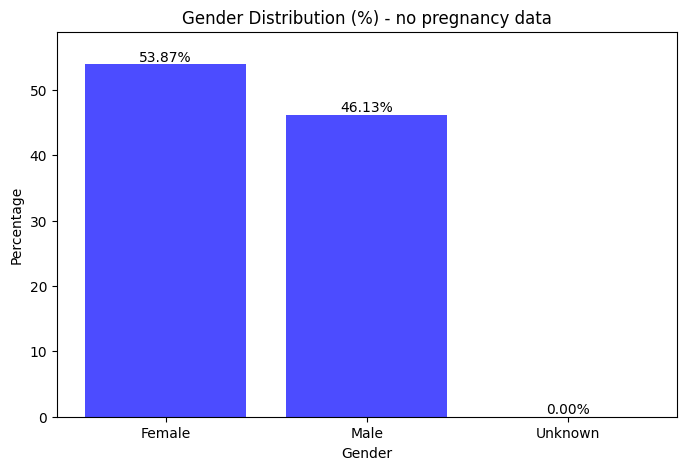

In [27]:
df_non_pregnancy['Patient Bio Gender'] = df_non_pregnancy['Patient Bio Gender Translated'].replace({'Kvinde': 'Female', 'Mand': 'Male', 'Ukendt': 'Unknown'})

# Count occurrences of each gender
gender_counts_non_pregnancy = df_non_pregnancy['Patient Bio Gender'].value_counts()

# Convert counts to percentages
gender_percentages_non_pregnancy = (gender_counts_non_pregnancy / gender_counts_non_pregnancy.sum()) * 100

plt.figure(figsize=(8, 5))
plt.bar(gender_percentages_non_pregnancy.index, gender_percentages_non_pregnancy.values, color=['blue'], alpha=0.7)
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Gender Distribution (%) - no pregnancy data')

# Show percentages on bars with higher precision for small values
for i, v in enumerate(gender_percentages_non_pregnancy.values):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontsize=10)  # More decimal places

# Adjust y-axis for better visibility
plt.ylim(0, max(gender_percentages_non_pregnancy.values) + 5)  # Dynamic y-axis scaling
plt.show()

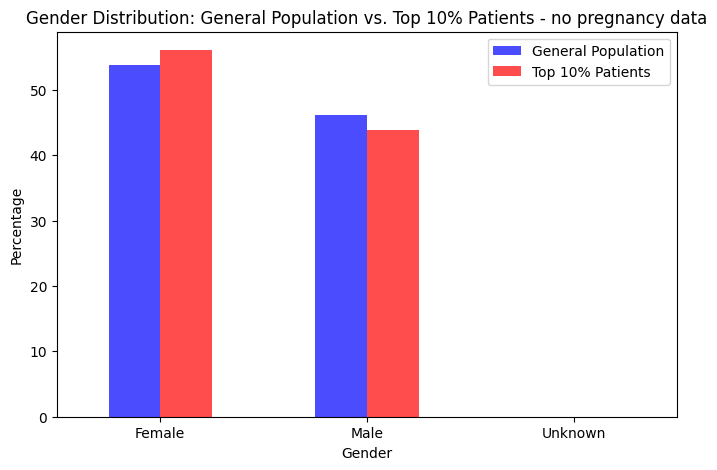

In [28]:
# Gender distribution for both groups
general_gender_dist_non_pregnancy = df_non_pregnancy['Patient Bio Gender Translated'].value_counts(normalize=True) * 100
top_gender_dist_non_pregnancy = top_patients_data_non_pregnancy['Patient Bio Gender Translated'].value_counts(normalize=True) * 100

# Create a dataframe for comparison
gender_comparison_non_pregnancy = pd.DataFrame({'General Population': general_gender_dist_non_pregnancy, 'Top 10% Patients': top_gender_dist_non_pregnancy}).fillna(0)

# Plot
gender_comparison_non_pregnancy.plot(kind='bar', figsize=(8, 5), color=['blue', 'red'], alpha=0.7)
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Gender Distribution: General Population vs. Top 10% Patients - no pregnancy data')
plt.xticks(rotation=0)
plt.legend()
plt.show()

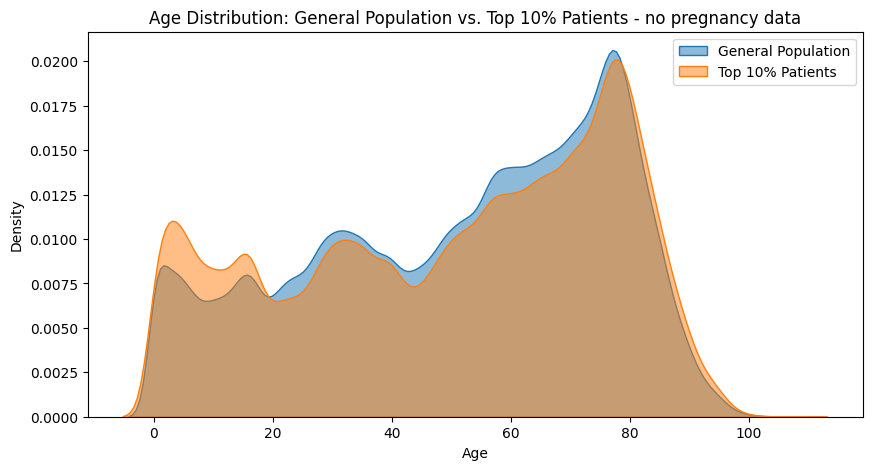

In [29]:
# General Population vs. High-Utilizers (Top 10% of patients)
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_non_pregnancy, x='Patient Age at Contact Start Time', label='General Population', fill=True, alpha=0.5)
sns.kdeplot(data=top_patients_data_non_pregnancy, x='Patient Age at Contact Start Time', label='Top 10% Patients', fill=True, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution: General Population vs. Top 10% Patients - no pregnancy data')
plt.legend()
plt.show()

/var/folders/42/jzdlm0tx6bld5l7c53yw5zjc0000gn/T/ipykernel_91487/3793222486.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_pregnancy['Duration Category'] = pd.cut(duration_hours_non_pregnancy, bins=bins, labels=labels, right=False)
/var/folders/42/jzdlm0tx6bld5l7c53yw5zjc0000gn/T/ipykernel_91487/3793222486.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_patients_data_non_pregnancy['Duration Category'] = pd.cut((top_patients_data_non_pregnancy['Contact End Date'] - top_patients_data_non_

<Figure size 1000x500 with 0 Axes>

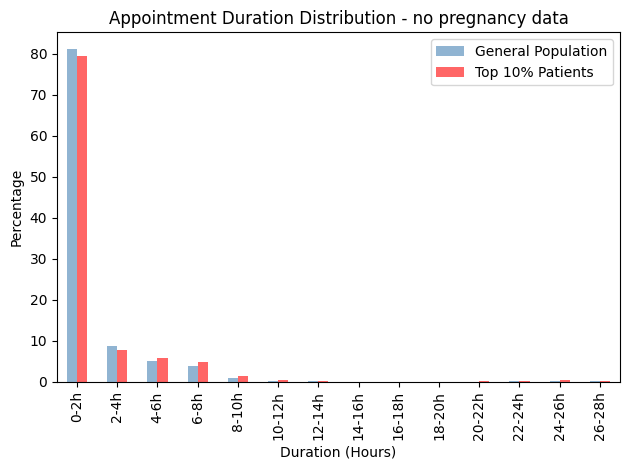

In [30]:
# Calculate duration in hours
duration_hours_non_pregnancy = (df_non_pregnancy['Contact End Date'] - df_non_pregnancy['Contact Start Date']).dt.total_seconds() / 3600

# Define custom bins (you can adjust the range as needed)
bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
labels = ['0-2h', '2-4h', '4-6h', '6-8h', '8-10h', '10-12h', '12-14h', '14-16h', '16-18h', '18-20h', '20-22h', '22-24h', '24-26h', '26-28h']

# Bin the durations
df_non_pregnancy['Duration Category'] = pd.cut(duration_hours_non_pregnancy, bins=bins, labels=labels, right=False)

# Subset data for top 10% patients
top_patients_data_non_pregnancy['Duration Category'] = pd.cut((top_patients_data_non_pregnancy['Contact End Date'] - top_patients_data_non_pregnancy['Contact Start Date']).dt.total_seconds() / 3600, bins=bins, labels=labels, right=False)

# Add a column to distinguish between general population and top 10% patients
df_non_pregnancy['Group'] = 'General Population'
top_patients_data_non_pregnancy['Group'] = 'Top 10% Patients'

# Combine the dataframes
combined_df_non_pregnancy = pd.concat([df_non_pregnancy, top_patients_data_non_pregnancy])

# Calculate percentages
duration_counts_non_pregnancy = combined_df_non_pregnancy.groupby(['Duration Category', 'Group']).size().unstack().fillna(0)
duration_percentages_non_pregnancy = duration_counts_non_pregnancy.div(duration_counts_non_pregnancy.sum(axis=0), axis=1) * 100

# Plot
plt.figure(figsize=(10, 5))
duration_percentages_non_pregnancy.plot(kind='bar', stacked=False, color=['steelblue', 'red'], alpha=0.6)
plt.title('Appointment Duration Distribution - no pregnancy data')
plt.xlabel('Duration (Hours)')
plt.ylabel('Percentage')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/42/jzdlm0tx6bld5l7c53yw5zjc0000gn/T/ipykernel_91487/712190687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_pregnancy['Hour of Day'] = df_non_pregnancy['Contact Start Date'].dt.hour


1994594


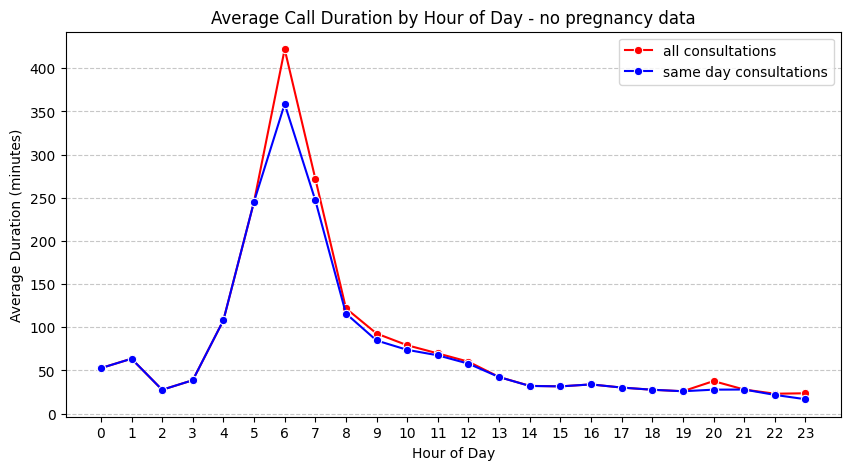

In [31]:
df_non_pregnancy['Hour of Day'] = df_non_pregnancy['Contact Start Date'].dt.hour

# group by hour of day
average_by_hour_non_pregnancy = df_non_pregnancy.groupby('Hour of Day')['Duration (minutes)'].mean().reset_index()


# filter data to only include one day consultations
one_day_data_non_pregnancy = df_non_pregnancy[df_non_pregnancy['Contact Start Date'].dt.date == df_non_pregnancy['Contact End Date'].dt.date]

average_by_hour_day_non_pregnancy = one_day_data_non_pregnancy.groupby('Hour of Day')['Duration (minutes)'].mean().reset_index()
print(len(one_day_data_non_pregnancy))
plt.figure(figsize=(10, 5))
sns.lineplot(data=average_by_hour_non_pregnancy, x='Hour of Day', y='Duration (minutes)', color='red', marker='o', label = "all consultations")
sns.lineplot(data=average_by_hour_day_non_pregnancy, x='Hour of Day', y='Duration (minutes)', color='blue', marker='o', label = "same day consultations")
plt.xlabel('Hour of Day')
plt.ylabel('Average Duration (minutes)')
plt.title('Average Call Duration by Hour of Day - no pregnancy data')
plt.xticks(range(24))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Physical vs Virtual Consultations

In [32]:
virtual_appointments = df['Contact Type Translated'].str.contains('Virtual', case=False, na=False)
physical_appointments = df['Contact Type Translated'].str.contains('Physical', case=False, na=False)
virtual_appointments_df = df[virtual_appointments]
physical_appointments_df = df[physical_appointments]

virtual_appointments_df

,Patient ID,Patient Contact ID,Patient Age at Contact Start Time,Contact Start Date,Contact End Date,Contact Type,Admission Method,Patient Contact Type,Primary Diagnosis Code,Secondary Diagnosis Code,...,Patient Municipality Translated,Primary Diagnosis Text,Group 3,Group 2,Group 1,Primary Diagnosis Text Translated,Patient Bio Gender,Duration (minutes),Duration Category,Hour of Day
809,Z4194438,1301025117527,0,2023-05-27 08:24:00,2023-05-27 08:54:00,Virtuel pt.kt.,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Male,30.0,0-2h,8
810,Z4216339,1301025831128,0,2023-07-14 10:46:00,2023-07-14 11:16:00,Virtuel pt.kt.,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Male,30.0,0-2h,10
811,Z4373868,1301029403213,0,2024-05-04 11:38:00,2024-05-04 12:08:00,Virtuel pt.kt.,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Male,30.0,0-2h,11
812,Z4440619,1301030634951,0,2024-09-01 15:48:00,2024-09-01 16:18:00,Virtuel pt.kt.,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Female,30.0,0-2h,15
813,Z4495027,1301031889202,0,2024-12-27 11:18:00,2024-12-27 11:48:00,Virtuel pt.kt.,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Male,30.0,0-2h,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300719,Z3480639,1301029112067,42,2024-04-12 13:00:00,2024-04-12 13:30:00,Virtuel pt.kt.,Planlagt,2 Ambulant,DZ340,DD696,...,Copenhagen,"Graviditet, førstegangsfødende",Personer i kontakt med sundhedsvæsenet i relat...,Personer i kontakt med sundhedsvæsenet i relat...,Faktorer af betydning for sundhedstilstand og ...,"Pregnancy, first-time feeding",Female,30.0,0-2h,13
2300720,Z3480639,1301029112067,42,2024-04-12 13:00:00,2024-04-12 13:30:00,Virtuel pt.kt.,Planlagt,2 Ambulant,DZ340,DO139,...,Copenhagen,"Graviditet, førstegangsfødende",Personer i kontakt med sundhedsvæsenet i relat...,Personer i kontakt med sundhedsvæsenet i relat...,Faktorer af betydning for sundhedstilstand og ...,"Pregnancy, first-time feeding",Female,30.0,0-2h,13
2300721,Z3480639,1301029112067,42,2024-04-12 13:00:00,2024-04-12 13:30:00,Virtuel pt.kt.,Planlagt,2 Ambulant,DZ340,DO991B,...,Copenhagen,"Graviditet, førstegangsfødende",Personer i kontakt med sundhedsvæsenet i relat...,Personer i kontakt med sundhedsvæsenet i relat...,Faktorer af betydning for sundhedstilstand og ...,"Pregnancy, first-time feeding",Female,30.0,0-2h,13
2300722,Z3524545,1301025345755,40,2023-06-15 13:27:00,2023-06-15 13:57:00,Virtuel pt.kt.,Planlagt,2 Ambulant,DZ340,DZ358N,...,Copenhagen,"Graviditet, førstegangsfødende",Personer i kontakt med sundhedsvæsenet i relat...,Personer i kontakt med sundhedsvæsenet i relat...,Faktorer af betydning for sundhedstilstand og ...,"Pregnancy, first-time feeding",Female,30.0,0-2h,13


In [33]:
physical_appointments_df


,Patient ID,Patient Contact ID,Patient Age at Contact Start Time,Contact Start Date,Contact End Date,Contact Type,Admission Method,Patient Contact Type,Primary Diagnosis Code,Secondary Diagnosis Code,...,Patient Municipality Translated,Primary Diagnosis Text,Group 3,Group 2,Group 1,Primary Diagnosis Text Translated,Patient Bio Gender,Duration (minutes),Duration Category,Hour of Day
0,Z4115614,1301023075465,0,2023-01-13 12:32:00,2023-01-13 13:02:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Male,30.0,0-2h,12
1,Z4115614,1301023121831,0,2023-01-15 13:27:00,2023-01-15 13:57:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Male,30.0,0-2h,13
2,Z4119225,1301023357249,0,2023-01-30 10:20:00,2023-01-30 10:50:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Male,30.0,0-2h,10
3,Z4127033,1301023443807,0,2023-02-04 12:46:00,2023-02-04 13:16:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Male,30.0,0-2h,12
4,Z4127033,1301023443875,0,2023-02-05 12:22:00,2023-02-05 12:52:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ001,NaN,...,Copenhagen,Kontakt mhp. planlagt generel børneundersøgelse,Personer i kontakt med sundhedsvæsenet med hen...,Personer i kontakt med sundhedsvæsenet med hen...,Faktorer af betydning for sundhedstilstand og ...,Contact for planned general children's examina...,Male,30.0,0-2h,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2302416,Z3524545,1301024819457,39,2023-05-30 08:28:00,2023-05-30 11:28:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Copenhagen,"Graviditet, førstegangsfødende",Personer i kontakt med sundhedsvæsenet i relat...,Personer i kontakt med sundhedsvæsenet i relat...,Faktorer af betydning for sundhedstilstand og ...,"Pregnancy, first-time feeding",Female,180.0,2-4h,8
2302417,Z3524545,1301024876038,39,2023-05-30 11:28:00,2023-05-30 12:08:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Copenhagen,"Graviditet, førstegangsfødende",Personer i kontakt med sundhedsvæsenet i relat...,Personer i kontakt med sundhedsvæsenet i relat...,Faktorer af betydning for sundhedstilstand og ...,"Pregnancy, first-time feeding",Female,40.0,0-2h,11
2302418,Z3524545,1301024938526,39,2023-05-31 09:26:00,2023-05-31 10:15:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Copenhagen,"Graviditet, førstegangsfødende",Personer i kontakt med sundhedsvæsenet i relat...,Personer i kontakt med sundhedsvæsenet i relat...,Faktorer af betydning for sundhedstilstand og ...,"Pregnancy, first-time feeding",Female,49.0,0-2h,9
2302419,Z3524545,1301025230953,40,2023-06-13 12:39:00,2023-06-13 13:20:00,Fysisk fremmøde,Planlagt,2 Ambulant,DZ340,DZ358N,...,Copenhagen,"Graviditet, førstegangsfødende",Personer i kontakt med sundhedsvæsenet i relat...,Personer i kontakt med sundhedsvæsenet i relat...,Faktorer af betydning for sundhedstilstand og ...,"Pregnancy, first-time feeding",Female,41.0,0-2h,12


### Top 20 of Virtual Visits Type

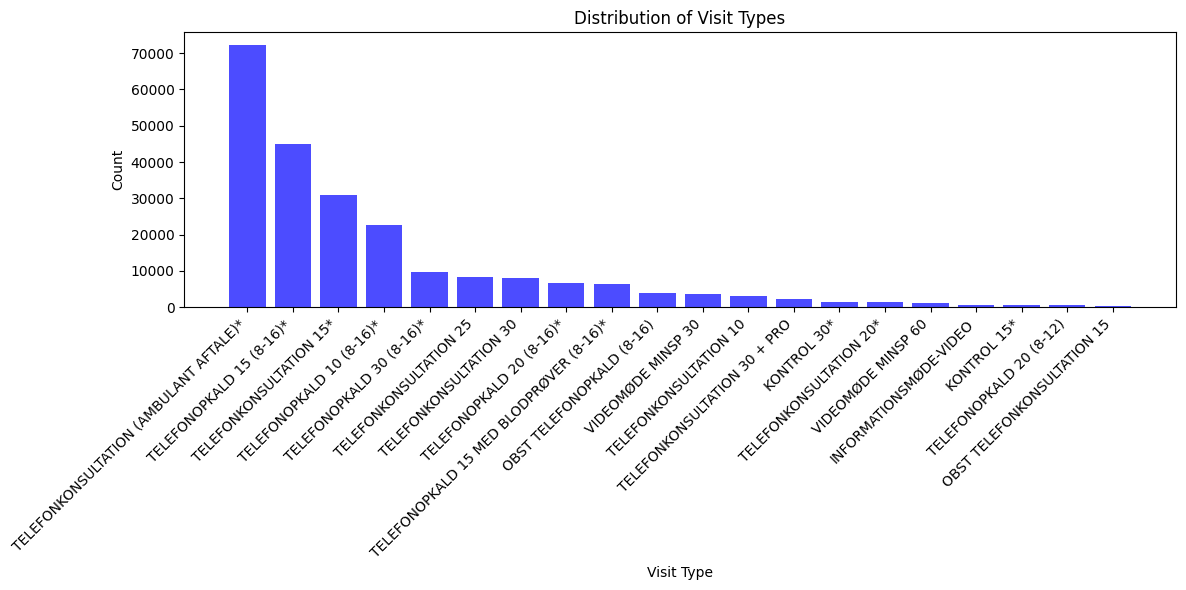

In [34]:
# Count occurrences of each visit type
visit_type_counts = virtual_appointments_df['Visit Type'].value_counts()

# Keep only the top 20 visit types so its visually user friendly
top_20_visit_types = visit_type_counts.head(20)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(top_20_visit_types.index, top_20_visit_types.values, color='blue', alpha=0.7)
plt.xlabel('Visit Type')
plt.ylabel('Count')
plt.title('Distribution of Visit Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Mean and Standard Deviation of Appointment Durations by Type

/var/folders/42/jzdlm0tx6bld5l7c53yw5zjc0000gn/T/ipykernel_91487/784530440.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  virtual_appointments_df['Appointment Type'] = 'Virtual'
/var/folders/42/jzdlm0tx6bld5l7c53yw5zjc0000gn/T/ipykernel_91487/784530440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  physical_appointments_df['Appointment Type'] = 'In-Person'


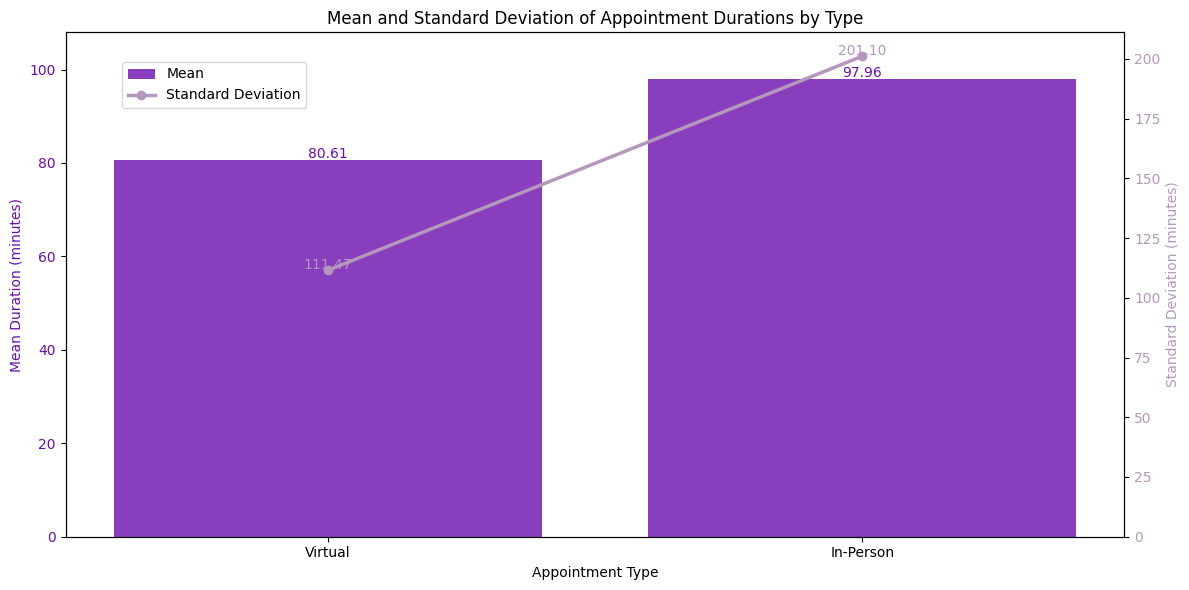

In [35]:
# Combine virtual and physical appointments into one DataFrame
virtual_appointments_df['Appointment Type'] = 'Virtual'
physical_appointments_df['Appointment Type'] = 'In-Person'
combined_appointments_df = pd.concat([virtual_appointments_df, physical_appointments_df])

# Calculate mean and standard deviation for each appointment type
mean_std_duration = combined_appointments_df.groupby('Appointment Type')['Duration (minutes)'].agg(['mean', 'std']).reset_index()

# Ensure "Virtual" is on the left and "In-Person" is on the right
mean_std_duration = mean_std_duration.set_index('Appointment Type').loc[['Virtual', 'In-Person']].reset_index()

# Plot the mean and standard deviation
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot mean 
# Plot mean
ax1.bar(mean_std_duration['Appointment Type'], mean_std_duration['mean'], color='#6A0DAD', alpha=0.8, label='Mean')  # Deep Purple
ax1.set_xlabel('Appointment Type')
ax1.set_ylabel('Mean Duration (minutes)', color='#6A0DAD')
ax1.tick_params(axis='y', labelcolor='#6A0DAD')
ax1.set_ylim(0, mean_std_duration['mean'].max() + 10)

# Add mean values on bars
for i, v in enumerate(mean_std_duration['mean']):
    ax1.text(i, v + 0.5, f"{v:.2f}", ha='center', fontsize=10, color='#6A0DAD')

# Create a second y-axis for standard deviation
ax2 = ax1.twinx()
ax2.plot(mean_std_duration['Appointment Type'], mean_std_duration['std'],
         color='#B497BD', marker='o', linestyle='-', linewidth=2.5, label='Standard Deviation')  # Lavender Gray
ax2.set_ylabel('Standard Deviation (minutes)', color='#B497BD')
ax2.tick_params(axis='y', labelcolor='#B497BD')
ax2.set_ylim(0, mean_std_duration['std'].max() + 10)

# Add standard deviation values on the line plot
for i, v in enumerate(mean_std_duration['std']):
    ax2.text(i, v + 0.5, f"{v:.2f}", ha='center', fontsize=10, color='#B497BD')


# Add title and legend
plt.title('Mean and Standard Deviation of Appointment Durations by Type')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

### Intersection of Visit Types between Physical and Virtual Appointments

In [36]:
# Check if physical_appointments_df and virtual_appointments_df have the same "Visit Types"
physical_visit_types = set(physical_appointments_df['Visit Type'].unique())
virtual_visit_types = set(virtual_appointments_df['Visit Type'].unique())

# Compare the visit types
common_visit_types = physical_visit_types.intersection(virtual_visit_types)
only_in_physical = physical_visit_types - virtual_visit_types
only_in_virtual = virtual_visit_types - physical_visit_types

print("Common Visit Types:", common_visit_types)
print("Visit Types only in Physical Appointments:", only_in_physical)
print("Visit Types only in Virtual Appointments:", only_in_virtual)

Common Visit Types: {nan, 'SYGEPLEJERSKE*', 'FU 60', 'TILPASNING AF COCHLEAR IMPLANT', 'PROTETIK UDLEVERING*', 'MDT2 (KONF MED PATIENT 30)', 'ÆGDONATION', 'FORSAMTALE CI', 'PRÆOPERATIV FORBEREDELSE', 'TELEFONOPKALD 15 MED BLODPRØVER (8-16)*', 'OBST KONSULTATION', 'SOCIALRÅDGIVER 60', 'INFUSION*', 'FORSAMTALE 45', 'JOURNALOPTAGELSE*', 'OBST STIK*', 'NY PATIENT 20', 'PATIENTKONFERENCE M. PT. 20', 'OBST VIBEVEJ 40', 'KONTROL FORVAGT 30 + RUM*', 'FORUNDERSØGELSE', 'KONTROL RYG', 'SAMTALE 30', 'HJERTE CT', 'KONTROL 90 BFH AUAM*', 'LÆGESAMTALE 45', 'EKKO BØRN', 'TELEFONOPKALD 30 (8-16)*', 'KONTROL M RØNTGEN 30', 'KONTROL TRANSITION 60', 'LEDPUNKTUR', 'OPFØLGENDE SAMTALE CANCER', 'KONTROL SPECIALLÆGE 30 + RUM*', 'ULTRALYDSSKANNING', 'TELEFONOPKALD 20 (8-16)*', 'KONTROL TVÆRFAGLIG 30', 'KONTROL 25', 'KONTROL 15 + BLOD', 'NY PATIENT 60*', 'PAKKE PT.', 'DAGHOSPITALSPATIENT 30', 'ØJENFOTO VOKSNE', 'FYSIOTERAPI 45', 'CD-SCANNING IVF/ICSI', 'OBST NY PT SPEC 60', 'POI OPFØLGNING 30', 'KONTROL 50', '

### Age Distribution: Virtual vs. In-Person Appointments

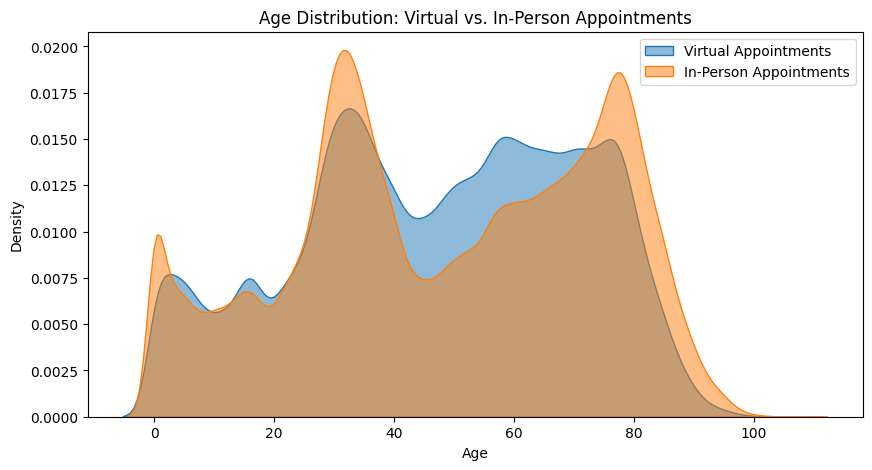

In [37]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=virtual_appointments_df, x='Patient Age at Contact Start Time', label='Virtual Appointments', fill=True, alpha=0.5)
sns.kdeplot(data=physical_appointments_df, x='Patient Age at Contact Start Time', label='In-Person Appointments', fill=True, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution: Virtual vs. In-Person Appointments')
plt.legend()
plt.show()

### Location analysis

In [38]:
# Initialize geolocator
geolocator = Nominatim(user_agent="denmark_postal_code_locator")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Get unique postal codes and their counts
postal_code_counts = virtual_appointments_df['Patient Postal Code'].value_counts()

# Create a DataFrame for postal codes and their counts
postal_code_df = pd.DataFrame({'Postal Code': postal_code_counts.index, 'Count': postal_code_counts.values})

# Get latitude and longitude for each postal code
postal_code_df['Location'] = postal_code_df['Postal Code'].apply(lambda x: geocode(f"{x}, Denmark"))
postal_code_df['Latitude'] = postal_code_df['Location'].apply(lambda loc: loc.latitude if loc else None)
postal_code_df['Longitude'] = postal_code_df['Location'].apply(lambda loc: loc.longitude if loc else None)

# Filter out rows with missing coordinates
postal_code_df = postal_code_df.dropna(subset=['Latitude', 'Longitude'])

# Create a map centered around Denmark
denmark_map = folium.Map(location=[56.26392, 9.501785], zoom_start=7)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('2300, Denmark',), **{}).
Traceback (most recent call last):
  File "/Users/raquel/opt/anaconda3/lib/python3.9/site-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/Users/raquel/opt/anaconda3/lib/python3.9/site-packages/urllib3/util/connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/Users/raquel/opt/anaconda3/lib/python3.9/socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/raquel/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/Users/raquel/opt/a

In [ ]:
# Keep only rows where 'Postal Code' contains only digits
postal_code_df = postal_code_df[postal_code_df['Postal Code'].astype(str).str.isdigit()]

# Aggregate counts by postal code
postal_code_df = postal_code_df.groupby('Postal Code').agg(
    {'Count': 'sum', 
     'Latitude': 'first', 
     'Longitude': 'first',
     }).reset_index()

postal_code_df

### Appointments outside of Denmark

In [ ]:
# Define Denmark's rough bounding box
min_lat, max_lat = 54.5, 58.0
min_lon, max_lon = 7.5, 15.5

# Filter rows outside this bounding box
outside_denmark = postal_code_df[
    (postal_code_df['Latitude'] < min_lat) | (postal_code_df['Latitude'] > max_lat) |
    (postal_code_df['Longitude'] < min_lon) | (postal_code_df['Longitude'] > max_lon)
]

# Print the postal codes that fall outside of Denmark
print("Postal codes outside of Danish territory:")
print(outside_denmark['Postal Code'].tolist())

________

In [ ]:
# Step 1: Log-transform the consultation counts
postal_code_df['Log Count'] = np.log1p(postal_code_df['Count'])

# Step 2: Sort so higher values appear on top
sorted_df = postal_code_df.sort_values(by='Count')

# Step 3: Create color scale
min_val = sorted_df['Log Count'].min()
max_val = sorted_df['Log Count'].max()

colormap = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],
    vmin=min_val,
    vmax=max_val
)
colormap.caption = "Log-scaled number of consultations"

# Step 4: Create map
denmark_map = folium.Map(location=[56.26392, 9.501785], zoom_start=7)

# Step 5: Add circles with smaller fixed size
for _, row in sorted_df.iterrows():
    count = row['Count']
    log_count = row['Log Count']

    if pd.notna(log_count):
        folium.Circle(
            location=[row['Latitude'], row['Longitude']],
            radius=4000,  
            color=None,
            fill=True,
            fill_color=colormap(log_count),
            fill_opacity=0.5,
            popup=(
                f"<b>Postal Code:</b> {row['Postal Code']}<br>"
                f"<b>Consultations:</b> {int(count)}"
            )
        ).add_to(denmark_map)

# Step 6: Add color legend
colormap.add_to(denmark_map)
denmark_map

In [ ]:
population_df = pd.read_excel("Postal code.xlsx")

In [ ]:
# Clean the Postal Code column to keep only the part after " - "
population_df['Postal Code Cleaned'] = population_df['Postal Code'].str.split(' - ').str[-1]

# Clean the Postal Code column to keep only the part after " - "
population_df['Postal Code Number'] = population_df['Postal Code Cleaned'].str.split(' ').str[0]

# Preview the result
print(population_df[['Postal Code', 'Postal Code Cleaned', 'Postal Code Number']].head())

                        Postal Code Postal Code Cleaned Postal Code Number
0  101 København - 1050 København K    1050 København K               1050
1  101 København - 1051 København K    1051 København K               1051
2  101 København - 1052 København K    1052 København K               1052
3  101 København - 1053 København K    1053 København K               1053
4  101 København - 1054 København K    1054 København K               1054


In [ ]:
# aggregate the data by Postal Code Number and sum the Population column
population_df = population_df.groupby('Postal Code Number')['Population'].sum().reset_index()
population_df

,Postal Code_x,Count,Location,Latitude,Longitude,Postal Code_y,Population,Postal Code Cleaned,Postal Code Number
0,2300,25196,"(2300, Københavns Kommune, Region Hovedstaden,...",55.650905,12.602597,101 København - 2300 København S,151236.0,2300 København S,2300
1,2300,25196,"(2300, Københavns Kommune, Region Hovedstaden,...",55.650905,12.602597,185 Tårnby - 2300 København S,12.0,2300 København S,2300
2,2100,25104,"(2100, Københavns Kommune, Region Hovedstaden,...",55.707117,12.572069,101 København - 2100 København Ø,91754.0,2100 København Ø,2100
3,2200,18814,"(2200, Københavns Kommune, Region Hovedstaden,...",55.694917,12.550125,101 København - 2200 København N,76709.0,2200 København N,2200
4,2200,18814,"(2200, Københavns Kommune, Region Hovedstaden,...",55.694917,12.550125,147 Frederiksberg - 2200 København N,125.0,2200 København N,2200
...,...,...,...,...,...,...,...,...,...
1805,1327.0,1,"(Denmark, Oxford County, Maine, 04022, United ...",43.970728,-70.803530,NaN,NaN,NaN,NaN
1806,823500,1,"(Denmark, Oxford County, Maine, 04022, United ...",43.970728,-70.803530,NaN,NaN,NaN,NaN
1807,1368.0,1,"(Denmark, Oxford County, Maine, 04022, United ...",43.970728,-70.803530,NaN,NaN,NaN,NaN
1808,1717.0,1,"(Denmark, Oxford County, Maine, 04022, United ...",43.970728,-70.803530,NaN,NaN,NaN,NaN


In [ ]:
postal_population_code_df = postal_code_df.merge(
    population_df,
    left_on='Postal Code',
    right_on='Postal Code Number',
    how='left'
)
postal_population_code_df

In [ ]:
# Step 1: Calculate consultations per 1,000 people
postal_population_code_df['Rate_per_1000'] = (
    postal_population_code_df['Count'] / postal_population_code_df['Population']
) * 1000
postal_population_code_df['Rate_per_1000'] = postal_population_code_df['Rate_per_1000'].round(2)

# Step 2: Use fixed color scale range (safe defaults)
vmin = 0
vmax = 200 

colormap = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],
    vmin=vmin,
    vmax=vmax
)
colormap.caption = "Consultations per 1,000 citizens"

# Step 3: Sort to draw higher values last (red on top)
sorted_df = postal_population_code_df.sort_values(by='Rate_per_1000')

# Step 4: Create the map
denmark_map = folium.Map(location=[56.26392, 9.501785], zoom_start=7)

# Step 5: Add markers
for _, row in sorted_df.iterrows():
    rate = row['Rate_per_1000']
    if pd.notna(rate):
        rate_clamped = min(max(rate, vmin), vmax)  # clamp to color scale range
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5,
            color=None,
            fill=True,
            fill_color=colormap(rate_clamped),
            fill_opacity=0.5,
            popup=(
                f"<b>Postal Code:</b> {row['Postal Code Number']}<br>"
                f"<b>Consultations per 1,000:</b> {rate:.2f}<br>"
                f"<b>Total Consultations:</b> {int(row['Count'])}<br>"
                f"<b>Population:</b> {int(row['Population'])}"
            )
        ).add_to(denmark_map)

# Step 6: Add legend
colormap.add_to(denmark_map)
denmark_map

In [ ]:
# Count occurrences of each visit type
visit_type_counts = virtual_appointments_df['Visit Type'].value_counts()

# Convert to list of tuples
visit_type_list = list(visit_type_counts.items())

# Display the list
visit_type_list

# Display the list in a scrollable format

html = "<div style='height: 200px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;'>"
html += "<ul>"
for item in visit_type_list:
    html += f"<li>{item[0]}: {item[1]}</li>"
html += "</ul></div>"

display(HTML(html))

In [ ]:
# Count occurrences of each visit type
visit_type_counts_in_person = physical_appointments_df['Visit Type'].value_counts()

# Convert to list of tuples
visit_type_list_in_person = list(visit_type_counts_in_person.items())

# Display the list
visit_type_list_in_person

# Display the list in a scrollable format

html = "<div style='height: 200px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;'>"
html += "<ul>"
for item in visit_type_list_in_person:
    html += f"<li>{item[0]}: {item[1]}</li>"
html += "</ul></div>"

display(HTML(html))

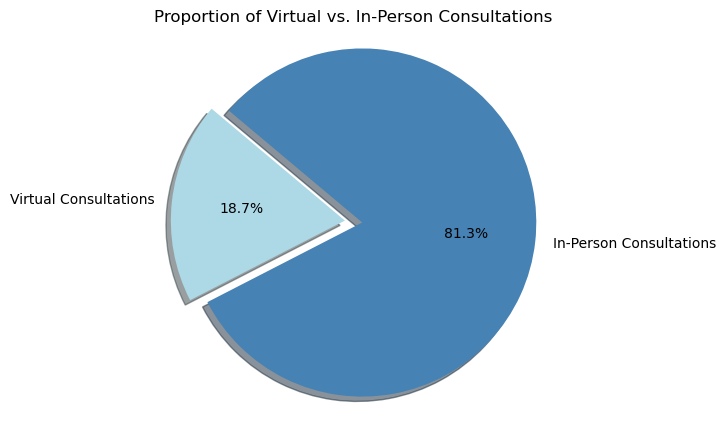

In [ ]:
# Calculate the counts of virtual and physical consultations
virtual_counts = virtual_appointments_df.shape[0]
physical_counts = physical_appointments_df.shape[0]

# Calculate the proportion of virtual consultations
proportion_virtual = virtual_counts / (virtual_counts + physical_counts)

# Create a pie chart to visualize the proportions
labels = ['Virtual Consultations', 'In-Person Consultations']
sizes = [proportion_virtual, 1 - proportion_virtual]
colors = ['#ADD8E6', '#4682B4']  # Updated colors: light blue and steel blue
explode = (0.1, 0)  # explode the first slice (i.e. 'Virtual Consultations')

plt.figure(figsize=(8, 5))
plt.pie(
    sizes, 
    explode=explode, 
    labels=labels, 
    colors=colors, 
    autopct=lambda p: f'{p:.1f}%', 
    textprops={'color': 'black'},  # Make text black
    shadow=True, 
    startangle=140
)
plt.title('Utilized Potential of Virtual Consultations (Virtual vs. In-Person Consultations)', color='black')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# Step 1: Create colormap
colormap = cm.LinearColormap(['blue', 'green', 'yellow', 'red'], vmin=0, vmax=1)
colormap.caption = "Andel virtuelle konsultationer"

# Step 2: Sort data so low proportions (blue) are drawn first
sorted_df = postal_code_df.sort_values(by='Proportion Virtual')

# Step 3: Create map
denmark_map_circles = folium.Map(location=[56.26392, 9.501785], zoom_start=7)

# Step 4: Draw cleaner, smaller circles
for _, row in sorted_df.iterrows():
    proportion = row['Proportion Virtual']
    if pd.notna(proportion):
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5,  
            color=None,  
            fill=True,
            fill_color=colormap(proportion),
            fill_opacity=0.5,
            popup=(
                f"<b>Postnummer:</b> {row['Postal Code']}<br>"
                f"<b>Andel virtuelle:</b> {proportion:.2%}<br>"
                f"<b>Antal patienter:</b> {int(postal_code_totals.get(row['Postal Code'], 0))}"
            )
        ).add_to(denmark_map_circles)

# Step 5: Add legend
colormap.add_to(denmark_map_circles)
denmark_map_circles

In [ ]:
# Set up a continuous color scale 
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'red'], vmin=0, vmax=1)
colormap.caption = "Utilized Potential of Virtual Consultations"

# Create the map
denmark_map = folium.Map(location=[56.26392, 9.501785], zoom_start=7)

# Add styled circle markers
for _, row in postal_code_df.iterrows():
    proportion = row['Proportion Virtual']
    if pd.notna(proportion):
        folium.Circle(
            location=[row['Latitude'], row['Longitude']],
            radius=3500,  
            color=None,
            fill=True,
            fill_color=colormap(proportion),
            fill_opacity=0.6 
        ).add_to(denmark_map)

# Add the color legend
colormap.add_to(denmark_map)
denmark_map

## Clustering 

In [ ]:
# Prepare data for clustering
df_cluster = df.copy()

# Rename for consistency
df_cluster = df_cluster.rename(columns={
    'Patient Age at Contact Start Time': 'Patient Age',
    'Admission Method Translated': 'Admission Method',
    'Responsible Treatment Department Translated': 'Department',
    'Visit Type Translated': 'Visit Type',
    'Contact Duration (hours)': 'Duration'
})

In [ ]:
# Features
features = ['Duration', 'Patient Age', 'Visit Type', 'Department', 'Admission Category']

# Preprocessing (dense output for PCA or further use)
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['Duration', 'Patient Age']),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), ['Visit Type', 'Department', 'Admission Category'])
])

# Preprocess features
X_preprocessed = preprocessor.fit_transform(df_cluster[features])

# Try different values of k and store inertia
inertias = []
k_values = range(2, 21)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_preprocessed)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Reuse your preprocessed data
X_preprocessed = preprocessor.fit_transform(df_cluster[features])

# Final KMeans clustering with chosen k
k = 5
kmeans_final = KMeans(n_clusters=k, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans_final.fit_predict(X_preprocessed)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)

# Plot PCA projection with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_cluster['Cluster'], palette='tab10', s=50)
plt.title('Consultation Clusters (PCA Projection, k=4)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
summary_num = df_cluster.groupby('Cluster')[['Duration', 'Patient Age']].mean().round(2)
print(summary_num)

In [ ]:
# Relative frequency of Visit Types in each cluster
visit_type_dist = df_cluster.groupby('Cluster')['Visit Type'].value_counts(normalize=True).unstack(fill_value=0).round(2)

# Same for Department
department_dist = df_cluster.groupby('Cluster')['Department'].value_counts(normalize=True).unstack(fill_value=0).round(2)

# And Admission Category
admission_dist = df_cluster.groupby('Cluster')['Admission Category'].value_counts(normalize=True).unstack(fill_value=0).round(2)

In [ ]:
cluster_summary = summary_num.copy()
cluster_summary['Most Common Visit Type'] = df_cluster.groupby('Cluster')['Visit Type'].agg(lambda x: x.mode().iloc[0])
cluster_summary['Most Common Department'] = df_cluster.groupby('Cluster')['Department'].agg(lambda x: x.mode().iloc[0])
cluster_summary['Admission Type (Mode)'] = df_cluster.groupby('Cluster')['Admission Category'].agg(lambda x: x.mode().iloc[0])

if 'Is Virtual' in df_cluster.columns:
    cluster_summary['% Virtual'] = df_cluster.groupby('Cluster')['Is Virtual'].mean().round(2) * 100

print(cluster_summary)